# Kaggle Competition: House Prices: Regression Analyses

# MSDS 422: Module 3 Assignment 1

## Requirements
1) Conduct your analysis using a cross-validation design.  
2) Conduct / improve upon previous EDA.  
3) Build models with many variables.  
4) Transform and feature engineer as appropriate.  
5) Build at a minimum the following regression models: Lasso, Ridge, ElasticNet.  
6) Conduct hyperparameter tuning for the ElasticNet.  
7) Evaluate performance of the model using the Kaggle metric upon which your scores are evaluated.  
8) Submit at least two models to Kaggle.com for evaluation. Provide your Kaggle.com user name and screen snapshots of your Kaggle scores.

## Data Preparation, Exploration, and Visualization

In this section, I want to use my previous EDA as a baseline and improve my data cleaning so that the linear regression models that I will use in the future can be more accurate. This will involve missing value imputation and creating dummy variables.

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import re
import numpy as np
from scipy import stats
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import xgboost as xgb

# Figures inline and set visualization style
%matplotlib inline
sns.set()

In [2]:
# import train and test sets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# store target variable of training data in a safe place
sale_price_train = train.SalePrice

# store ID column separately since it is useless for prediction
train_id = train.Id
test_id = test.Id

train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

# concatenate training and test sets for EDA
data = pd.concat([train.drop(['SalePrice'], axis=1), test])

In [4]:
# showing the first few rows of the data
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In my last EDA, I placed a heavy emphasis on exploring numerical variables. However, just by looking at the first few rows of the `data` DataFrame, we can see that we really have a lot more than just numerical data. It's important to use these variables as well for our regression models later.

Let's explore beyond what we have already explored in the `eda.ipynb`, which is from Module 1 Assignment 1. I would like to explore the proportion of missing data for each column.

In [5]:
data_null = ((data.isnull().sum() / len(data)) * 100).sort_values(ascending=False)
missing_data = pd.DataFrame({"Percentage of Missing Data": data_null})
missing_data.head()

,Percentage of Missing Data
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797


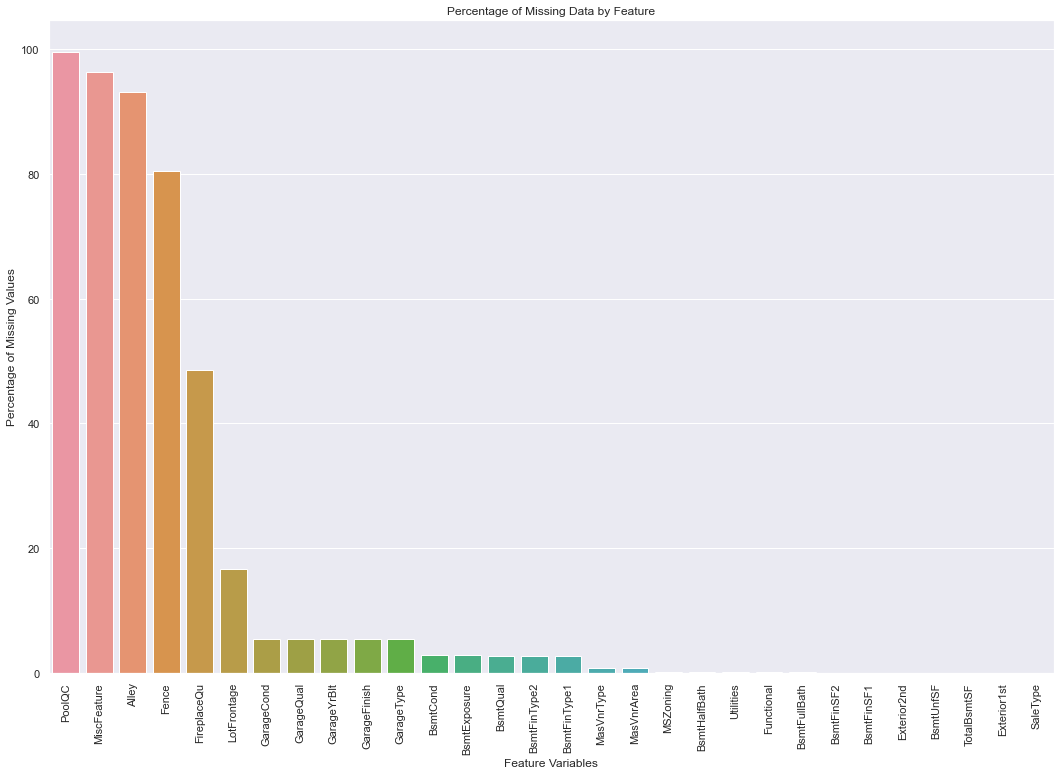

In [6]:
# plotting a bar plot to compare the variables and their proportion of missing data
fig, ax = plt.subplots(figsize=(18, 12))
plt.xticks(rotation="90")
short_missing_data = missing_data.iloc[:30]
sns.barplot(x=short_missing_data.index, y=short_missing_data["Percentage of Missing Data"], data=short_missing_data)
plt.xlabel("Feature Variables")
plt.ylabel("Percentage of Missing Values")
plt.title("Percentage of Missing Data by Feature");

**Insights:** PoolQC, MiscFeature, Alley, and Fence are the variables that have the most amount of missing data. We should investigate the variables with missing data, and figure out what NaN values mean for these variables.

In [7]:
missing_data = missing_data.loc[missing_data["Percentage of Missing Data"] > 0]
missing_data.tail()

,Percentage of Missing Data
SaleType,0.034258
Electrical,0.034258
KitchenQual,0.034258
GarageArea,0.034258
GarageCars,0.034258


In [8]:
print(f"We have to explore {len(missing_data)} columns and their null value meanings")

We have to explore 34 columns and their null value meanings


### Missing Value Imputation

I will go in order by highest percentage of missing data from the `missing_data` DF, and will refer to the Kaggle data dictionary for this comptetition, found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=test.csv).

In [9]:
missing_data.index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageCond', 'GarageQual', 'GarageYrBlt', 'GarageFinish', 'GarageType',
       'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
       'MasVnrType', 'MasVnrArea', 'MSZoning', 'BsmtHalfBath', 'Utilities',
       'Functional', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtFinSF1', 'Exterior2nd',
       'BsmtUnfSF', 'TotalBsmtSF', 'Exterior1st', 'SaleType', 'Electrical',
       'KitchenQual', 'GarageArea', 'GarageCars'],
      dtype='object')

- **PoolQC:** This is pool quality. A value of "NA" means there is no pool. Thus, we should impute this properly with the value "No Pool" for clarity.

In [10]:
data["PoolQC"].fillna("None", inplace=True)

# checking that "inplace" works for fillna
data[["PoolQC"]].head()

,PoolQC
0,None
1,None
2,None
3,None
4,None


- **MiscFeature**: Data description says this is miscellaneous feature not covered in other categories. A value of "NA" means there are no misc features. We can encode this is "None" instead.

In [11]:
data["MiscFeature"].fillna("None", inplace=True)

- **Alley:** This is the type of alley access to property. NA means no alley access. We can encode this with "None."

In [12]:
data["Alley"].fillna("None", inplace=True)

- **Fence:** This is fence quality. NA means no fence. 

In [13]:
data["Fence"].fillna("None", inplace=True)

- **FireplaceQu**: Fireplace quality. NA means no fireplace.

In [14]:
data["FireplaceQu"].fillna("None", inplace=True)

- **LotFrontage:** Linear feet of street connected to property. This is a numerical value, so we should impute the values with the median value. Because LotFrontage is likely similar for each house in the same neighborhood, we should group by neighborhood to find the proper median value.

In [15]:
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Double checking that this worked
(data[["LotFrontage"]].isnull().sum() / len(data)) * 100

LotFrontage    0.0
dtype: float64

- **GarageCond, GarageQual, GarageFinish, GarageType**: Any NA values within these columns mean "no garage". We can encode with None.

In [16]:
for c in ["GarageCond", "GarageQual", "GarageFinish", "GarageType"]:
    data[c].fillna("None", inplace=True)

- **GarageYrBlt, GarageArea, GarageCars**: These are numerical values, so NA values should be replaced with the value of 0 rather than a string like "None." NA values mean there is no garage, so imputing with 0 makes more sense.

In [17]:
for c in ["GarageYrBlt", "GarageArea", "GarageCars"]:
    data[c].fillna(0, inplace=True)

- **BsmtCond, BsmtExposure, BsmtQual, BsmtFinType1, BsmtFinType2:** These are qualitative variables about the basement, where the NA values mean there is no basement. We can encode these with "None" instead.

In [18]:
for c in ["BsmtCond", "BsmtExposure", "BsmtQual", "BsmtFinType1", "BsmtFinType2"]:
    data[c].fillna("None", inplace=True)

- **BsmtHalfBath, BsmtFullBath, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF:** These are numerical variables about the basement, where the NA values should be translated to 0 since there are none of these features regarding basement.

In [19]:
for c in ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]:
    data[c].fillna(0, inplace=True)

- **MasVnrType, MasVnrArea:** Having an NA value likely means that there is no masonry veneer. Unfortunately, the data dictionary does not describe this. I would be wary of this variable and likely drop it in the future, or ensure that these variables have minimal weight in the linear regression model.

In [20]:
# qualitative variable
data["MasVnrType"].fillna("None", inplace=True)

# quantitative variable
data["MasVnrArea"].fillna(0, inplace=True)

- **MSZoning:** Identifies the general zoning classification of the sale. We can fill it in with the mode of this variable since it is qualitative. We see that "RL" is the most common value for this feature.

In [21]:
data["MSZoning"].mode()

0    RL
dtype: object

In [22]:
data["MSZoning"].fillna(data["MSZoning"].mode()[0], inplace=True)

- **Utilities:** Type of utilities available. Data dictionary does not specify what NA values mean. For this column, we see below from the code that only 2 values are null values, and that the rest of the data (except one) is AllPub, meaning this column may not be useful in prediction. We could fill in the missing values with "AllPub" since it is the mode, but should be wary of this column and possibly drop it in the future.

In [23]:
data[["Utilities"]].isna().sum()

Utilities    2
dtype: int64

In [24]:
data[["Utilities"]].value_counts()

Utilities
AllPub       2916
NoSeWa          1
dtype: int64

In [25]:
data["Utilities"].fillna(data["Utilities"].mode()[0], inplace=True)

- **Functional:** According to data description, this is home functionality, and we should assume typical unless deductions are warranted. Thus, let's fill the null values with "Typ." We only have 2 NA values, but should not drop this column later since this feature takes many different values.

In [26]:
data[["Functional"]].isna().sum()

Functional    2
dtype: int64

In [27]:
data[["Functional"]].value_counts()

Functional
Typ           2717
Min2            70
Min1            65
Mod             35
Maj1            19
Maj2             9
Sev              2
dtype: int64

In [28]:
data["Functional"].fillna("Typ", inplace=True)

- **Exterior1st, Exterior2nd:** Exterior covering on house (2nd: if more than one material). This takes on many values, so let's fill it in with the mode. Note that we only have 1 missing value for each of these columns.

In [29]:
data[["Exterior1st"]].isna().sum()

Exterior1st    1
dtype: int64

In [30]:
data[["Exterior1st"]].value_counts()

Exterior1st
VinylSd        1025
MetalSd         450
HdBoard         442
Wd Sdng         411
Plywood         221
CemntBd         126
BrkFace          87
WdShing          56
AsbShng          44
Stucco           43
BrkComm           6
Stone             2
CBlock            2
AsphShn           2
ImStucc           1
dtype: int64

In [31]:
data[["Exterior2nd"]].isna().sum()

Exterior2nd    1
dtype: int64

In [32]:
data[["Exterior2nd"]].value_counts()

Exterior2nd
VinylSd        1014
MetalSd         447
HdBoard         406
Wd Sdng         391
Plywood         270
CmentBd         126
Wd Shng          81
Stucco           47
BrkFace          47
AsbShng          38
Brk Cmn          22
ImStucc          15
Stone             6
AsphShn           4
CBlock            3
Other             1
dtype: int64

In [33]:
data["Exterior1st"].fillna(data["Exterior1st"].mode()[0], inplace=True)
data["Exterior2nd"].fillna(data["Exterior2nd"].mode()[0], inplace=True)

- **SaleType:** Type of sale. We only have one missing value. Let's fill it in with the mode, which is "WD", meaning Warranty Deed - Conventional.

In [34]:
data[["SaleType"]].isna().sum()

SaleType    1
dtype: int64

In [35]:
data[["SaleType"]].value_counts()

SaleType
WD          2525
New          239
COD           87
ConLD         26
CWD           12
ConLI          9
ConLw          8
Oth            7
Con            5
dtype: int64

In [36]:
data["SaleType"].fillna(data["SaleType"].mode()[0], inplace=True)

- **Electrical:** Electrical system. Only one null value. We can fill it in with the mode, which is Sbrkr.

In [37]:
data[["Electrical"]].isna().sum()

Electrical    1
dtype: int64

In [38]:
data[["Electrical"]].value_counts()

Electrical
SBrkr         2671
FuseA          188
FuseF           50
FuseP            8
Mix              1
dtype: int64

In [39]:
data["Electrical"].fillna(data["Electrical"].mode()[0], inplace=True)

- **KitchenQual:** Kitchen quality. Only one null value. Can fill in with the mode, which is "Typical/Average".

In [40]:
data[["KitchenQual"]].isna().sum()

KitchenQual    1
dtype: int64

In [41]:
data[["KitchenQual"]].value_counts()

KitchenQual
TA             1492
Gd             1151
Ex              205
Fa               70
dtype: int64

In [42]:
data["KitchenQual"].fillna(data["KitchenQual"].mode()[0], inplace=True)

Finally, let's double check that we have no missing data.

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2919 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

Success!

Something else that concerned me from the last EDA notebook is that the distribution of `SalePrice` is positively skewed. We discussed in class that we should apply some transformation to this variable because linear models assume that the target variable is also linear.

In [44]:
# stealing this from a YouTube video (will link below)
def plotting_3_chart(df, feature):
    fig, axes = plt.subplots(3, 1, figsize=(15,15))
    
    # customizing histogram grid
    # set title
    axes[0].set_title("Histogram")
    # plot histogram
    sns.histplot(x=feature, data=df, kde=True, ax=axes[0])
    
    # customizing qq plot
    # set title
    axes[1].set_title("QQ Plot")
    # plot qq plot
    stats.probplot(x=df.loc[:, feature], plot=axes[1])
    
    # customizing box plot
    # set title
    axes[2].set_title("Box Plot")
    # plot box plot
    sns.boxplot(x=feature, data=df, ax=axes[2])

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


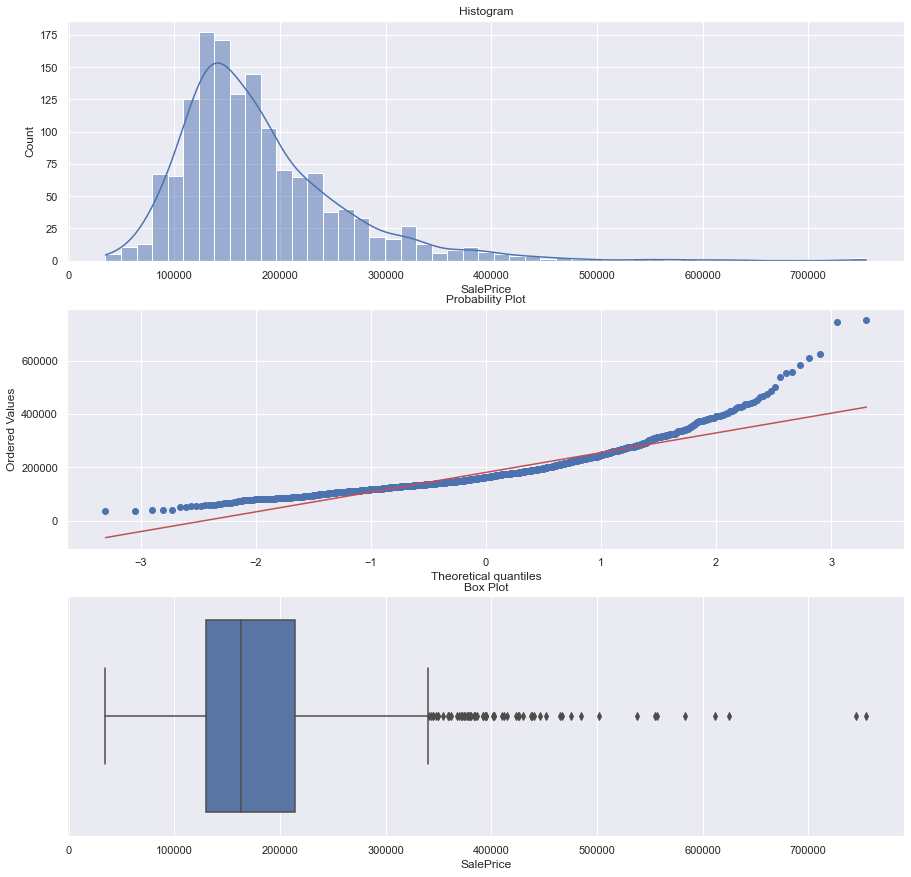

In [45]:
plotting_3_chart(train, "SalePrice")

# skewness and kurtosis
print(f"Skewness: {train['SalePrice'].skew()}")
print(f"Kurtosis: {train['SalePrice'].kurt()}")

The high value of skewness confirms that `SalePrice` is positively skewed. The high value of kurtosis indicates that the data is very peaked around the mean/median. A more normal distribution would have a kurtosis value of about 3, but our kurtosis value is doubled. Not good!    


We can also see that the probability plot is curved, suggesting nonlinearity. A log transformation will help us in this situation to create a more normal distribution.

Skewness: 0.12134661989685329
Kurtosis: 0.809519155707878


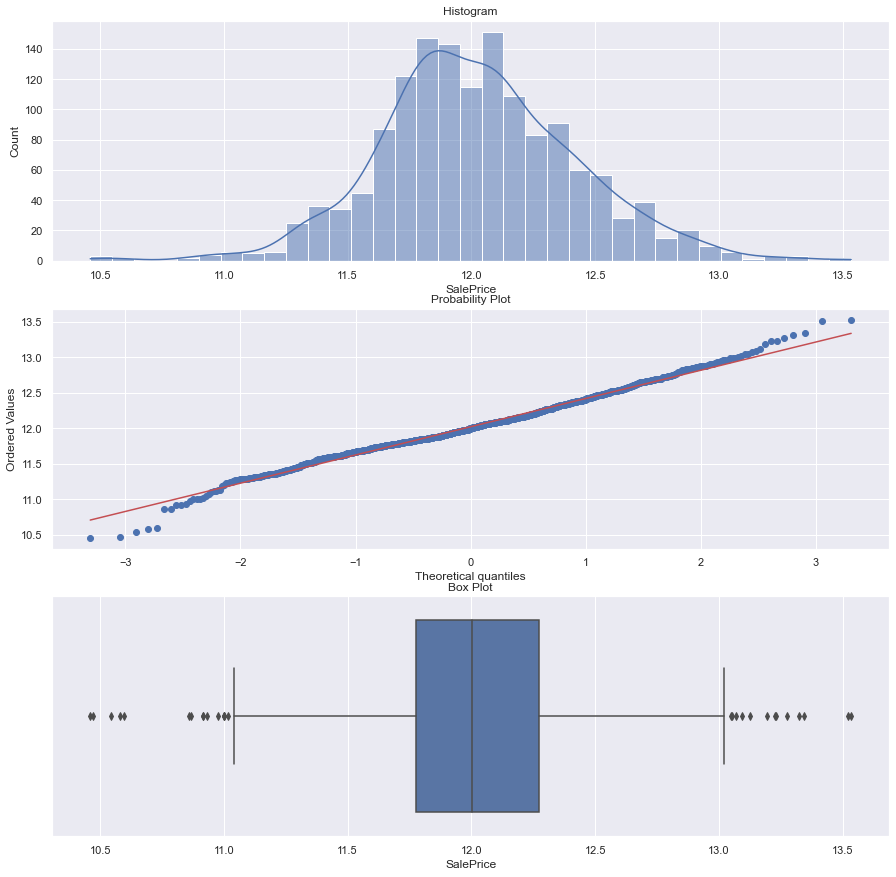

In [46]:
# store log of target variable of training data in a safe place
sale_price_train_log = np.log1p(train['SalePrice'])

train["SalePrice"] = sale_price_train_log

# plot
plotting_3_chart(train, "SalePrice")

# skewness and kurtosis
print(f"Skewness: {train['SalePrice'].skew()}")
print(f"Kurtosis: {train['SalePrice'].kurt()}")

**Insights:** We see that `SalePriceLog` has become more normalized. The lower values of skewness and kurtosis indicate this, as well as the probability plot. From the box plot, we still see some outliers. We may or may not need to drop these outliers, but for now, I don't think it's a good idea because we have multiple outliers that can indicate some uniqueness for those homes, which need to receive a proper and accurate prediction in case the test set also includes outliers such as these.

## Feature Engineering

Based on `data.info()` from the previous cell of code that was run, some features should not be integers, such as "MSSubClass". Let's fix that by turning variables into a string.

In [47]:
int_vars_to_string = ["MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "GarageYrBlt", 
                      "YrSold", "MoSold"]
for c in int_vars_to_string:
    data[c] = data[c].astype(str)

Let's combine some features to remove features that may be collinear, such as a value of `TotalSQFT` that is just the SQFT of basement, 1st floor, and 2nd floor combined.

In [48]:
# total sqft column
data["TotalSF"] = data["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"]

# concatenating string Year values to create uniqueness and later bin
# got this idea from a YouTube video, but I find it useless
# data["YrBuiltRemod"] = data["YearBuilt"] + data["YearRemodAdd"]

# total number of bathrooms
data["TotalBathrooms"] = data["FullBath"] + data["HalfBath"] + data["BsmtFullBath"] + data["BsmtHalfBath"]

Before using `pd.get_dummies()`, we should create dummy variables of our own for certain features, such as whether or not a house has a pool, garage, 2nd floor, etc. like I did in the EDA notebook.

In [49]:
data["Has2ndFlr"] = data[["2ndFlrSF"]].apply(lambda x: x > 0)
data["HasBsmt"] = data[["TotalBsmtSF"]].apply(lambda x: x > 0)
data["HasPool"] = data[["PoolArea"]].apply(lambda x: x > 0)
data["HasGarage"] = data[["GarageArea"]].apply(lambda x: x > 0)
data["HasFireplace"] = data[["Fireplaces"]].apply(lambda x: x > 0)

Something I want to add is whether or not a house was remodeled. This is super important in sales because buyers prefer more modern homes.

In [50]:
remod = []
temp_data = data.reset_index()
for i in range(len(temp_data)):
    remod.append(temp_data.loc[i, "YearBuilt"] != temp_data.loc[i, "YearRemodAdd"])
    
data["RemodAdd"] = remod
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleType,SaleCondition,TotalSF,TotalBathrooms,Has2ndFlr,HasBsmt,HasPool,HasGarage,HasFireplace,RemodAdd
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,WD,Normal,2566.0,4.0,True,True,False,True,False,False
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,WD,Normal,2524.0,3.0,False,True,False,True,True,False
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,WD,Normal,2706.0,4.0,True,True,False,True,True,True
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,WD,Abnorml,2473.0,2.0,True,True,False,True,True,True
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,WD,Normal,3343.0,4.0,True,True,False,True,True,False


### Binning Categorical Data: Custom Encoding
During this week's lecture, Larry and John suggested that I should bin the categorical data. This makes sense since when we explored the values of specific variables during missing value imputation, we can see that some variables have a lot of a specific value, and minimal amounts of other values. It would be best to bin those low amounts to create better regression analyses and improve our Kaggle scores.    

Below, I will perform custom encoding to determine whether or not a specific value in a categorical column is the most popular value or not. This should only be done for columns that have an extreme mode for a specific value. Let's look at each column one by one. Then, I will use pd.get_dummies() for other categorical columns where I didn't use custom encoding.    

- `PoolQC`

In [51]:
data["PoolQC"].value_counts()

None    2909
Gd         4
Ex         4
Fa         2
Name: PoolQC, dtype: int64

In [52]:
data["HasPool"].value_counts()

False    2906
True       13
Name: HasPool, dtype: int64

In [53]:
data["PoolArea"].value_counts()

0      2906
561       1
555       1
519       1
800       1
738       1
648       1
576       1
512       1
480       1
444       1
368       1
228       1
144       1
Name: PoolArea, dtype: int64

In [54]:
data.loc[(data["HasPool"] == True) & (data["PoolQC"] == "None"), ["HasPool", "PoolQC", "PoolArea"]]

,HasPool,PoolQC,PoolArea
960,True,None,368
1043,True,None,444
1139,True,None,561


**Insights:** The `PoolQC` column primarily has "None" values. We can see there is an anomaly from our previous custom column that we created called `HasPool`. Through missing value imputation, the houses above have a `PoolArea` value that is greater than 0, but did not have a value for PoolQC. I don't want to improperly encode these variables, so I will drop the `PoolQC` column and rely on `HasPool` instead.

In [55]:
# I will drop the columns at once at the end of this section before model training to do it in one go
columns_to_drop = ["PoolQC"]

In [56]:
all_columns = set(data.columns.to_list())
numeric_columns = set(data._get_numeric_data().columns.to_list())
categorical_columns = all_columns - numeric_columns
assert len(numeric_columns) + len(categorical_columns) == len(all_columns)
print(categorical_columns)

{'GarageCond', 'BsmtFinType1', 'MasVnrType', 'HouseStyle', 'Heating', 'YearRemodAdd', 'LotShape', 'GarageQual', 'RoofStyle', 'Fence', 'CentralAir', 'LotConfig', 'MSZoning', 'ExterQual', 'Condition1', 'LandSlope', 'Electrical', 'SaleType', 'ExterCond', 'MSSubClass', 'RoofMatl', 'Exterior2nd', 'MoSold', 'Utilities', 'BsmtQual', 'Alley', 'OverallCond', 'OverallQual', 'GarageYrBlt', 'KitchenQual', 'GarageType', 'Neighborhood', 'YearBuilt', 'HeatingQC', 'Street', 'FireplaceQu', 'BsmtCond', 'GarageFinish', 'SaleCondition', 'Functional', 'LandContour', 'BsmtExposure', 'Exterior1st', 'YrSold', 'BldgType', 'Foundation', 'PoolQC', 'MiscFeature', 'PavedDrive', 'Condition2', 'BsmtFinType2'}


- `KitchenQual`

In [57]:
data["KitchenQual"].value_counts()

TA    1493
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64

**Insights:** It seems like values of `KitchenQual` are pretty spaced out, and it would be inappropriate to bin "excellent" and "fair" qualities together. I will leave this as is.    

- `FireplaceQu`

In [58]:
data["FireplaceQu"].value_counts()

None    1420
Gd       744
TA       592
Fa        74
Po        46
Ex        43
Name: FireplaceQu, dtype: int64

**Insights:** When reading the data description for this variable, it also seems inappropriate to bin Fair or Poor with Typical/Average because each value has a different meaning about the fireplace. For instance, a value of Fair means the fireplace is a prefabricated fireplace in the basement, while a value of Poor means the fireplace is a Ben Franklin Stove. I will leave this one as is.    

It is a lot to show each and every column I am looking at. From now on, I will only show a column's value counts if I feel I should manipulate the column.    

- `Functional`

In [59]:
data["Functional"].value_counts()

Typ     2719
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

We should bin this data. There are 4 main categories, but this variable has 7 instead, and these are: typical, minor, moderate, and major. I will combine Min1 and Min2 as Min; Maj1, Maj2, and Sev as Maj. 

In [60]:
# this dictionary has column name mapped to column values that need to be replaced 
# mapped to the value to replace the value with

# So we can easily change all columns at once
cleanup_replace = {"Functional": {"Min1": "Min", "Min2": "Min", "Maj1": "Maj", "Maj2": "Maj", "Sev": "Maj"}}

- `Heating`

In [61]:
data["Heating"].value_counts()

GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64

We should also bin `Heating` data. We can bin it as Gas and Other, since Gas is the most popular one.

In [62]:
# adding to cleanup_replace dictionary
cleanup_replace["Heating"] = {"GasA": "Gas", "GasW": "Gas", "Grav": "Other", 
                              "Wall": "Other", "OthW": "Other", "Foor": "Other"}

# checking that I added to dictionary correctly
cleanup_replace

{'Functional': {'Min1': 'Min',
  'Min2': 'Min',
  'Maj1': 'Maj',
  'Maj2': 'Maj',
  'Sev': 'Maj'},
 'Heating': {'GasA': 'Gas',
  'GasW': 'Gas',
  'Grav': 'Other',
  'Wall': 'Other',
  'OthW': 'Other',
  'Foor': 'Other'}}

- `SaleType`

In [63]:
data["SaleType"].value_counts()

WD       2526
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

We should replace any value that is not "WD" or "New" with "Other" for simplicity.

In [64]:
# adding to cleanup_replace dictionary
cleanup_replace["SaleType"] = {"COD": "Other", "ConLD": "Other", "CWD": "Other", 
                              "ConLI": "Other", "ConLW": "Other", "Oth": "Other", "Con": "Other"}

- `RoofMat1`

In [65]:
data["RoofMatl"].value_counts()

CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
ClyTile       1
Metal         1
Roll          1
Membran       1
Name: RoofMatl, dtype: int64

The most popular value for `RoofMat1` is "CompShg". The rest are very low, so I'll change it to "other".

In [66]:
# adding to cleanup_replace dictionary
cleanup_replace["RoofMatl"] = {"Tar&Grv": "Other", "WdShake": "Other", "WdShngl": "Other", 
                              "Metal": "Other", "Roll": "Other", "Membran": "Other", "ClyTile": "Other"}

- `RoofStyle`

In [67]:
data["RoofStyle"].value_counts()

Gable      2310
Hip         551
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64

`RoofStyle` has only two popular values. The rest can be encoded as "Other".

In [68]:
# adding to cleanup_replace dictionary
cleanup_replace["RoofStyle"] = {"Gambrel": "Other", "Flat": "Other", "Mansard": "Other", 
                              "Shed": "Other"}

- `Condition2`: The most popular value is "Norm", and the rest of the values are barely present in the data. We can encode these as "Other".

In [69]:
data["Condition2"].value_counts()

Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAe         1
RRAn         1
Name: Condition2, dtype: int64

In [70]:
# adding to cleanup_replace dictionary
cleanup_replace["Condition2"] = {"Feedr": "Other", "Artery": "Other", "PosA": "Other", 
                              "PosN": "Other", "RRNn": "Other", "RRAe": "Other", "RRAn": "Other"}

- `Alley`: This column mostly has "None", meaning most of these homes have no alley access. Maybe it is best to drop this column and create a "HasAlley" column.

In [71]:
data["Alley"].value_counts()

None    2721
Grvl     120
Pave      78
Name: Alley, dtype: int64

In [72]:
columns_to_drop.append("Alley")
data["HasAlley"] = data[["Alley"]].apply(lambda x: x != "None")
data[["HasAlley"]].head()

,HasAlley
0,False
1,False
2,False
3,False
4,False


- `Foundation`: There are 3 common values: PConc, CBlock, and BrkTil. The rest will be "Other" instead.

In [73]:
data["Foundation"].value_counts()

PConc     1308
CBlock    1235
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: Foundation, dtype: int64

In [74]:
# adding to cleanup_replace dictionary
cleanup_replace["Foundation"] = {"Slab": "Other", "Stone": "Other", "Wood": "Other"}

- `Condition1`: Same as `Condition2` from above.

In [75]:
# to see proportions instead
data["Condition1"].value_counts(normalize=True)

Norm      0.860226
Feedr     0.056184
Artery    0.031518
RRAn      0.017129
PosN      0.013361
RRAe      0.009592
PosA      0.006852
RRNn      0.003083
RRNe      0.002055
Name: Condition1, dtype: float64

In [76]:
# adding to cleanup_replace dictionary
cleanup_replace["Condition1"] = {"Feedr": "Other", "Artery": "Other", "PosA": "Other", 
                              "PosN": "Other", "RRNn": "Other", "RRAe": "Other", "RRAn": "Other", 
                                "RRNe": "Other"}

- `Electrical`: Although different "Fuse" values mean the different qualities, it still makes up a very small amount of the data. I'll just label anything other than "Sbrkr" as "Other."

In [77]:
data["Electrical"].value_counts()

SBrkr    2672
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [78]:
# adding to cleanup_replace dictionary
cleanup_replace["Electrical"] = {"FuseA": "Other", "FuseF": "Other", 
                                 "FuseP": "Other", "Mix": "Other"}

- `BsmtFinType2`: Any value other than "Unf" or "None" is atypical. I'll encode these as "Other."

In [79]:
# seeing proportions instead
data["BsmtFinType2"].value_counts(normalize=True)

Unf     0.854060
Rec     0.035971
LwQ     0.029805
None    0.027407
BLQ     0.023296
ALQ     0.017814
GLQ     0.011648
Name: BsmtFinType2, dtype: float64

In [80]:
# adding to cleanup_replace dictionary
cleanup_replace["BsmtFinType2"] = {"Rec": "Other", "LwQ": "Other", "BLQ": "Other", 
                                   "ALQ": "Other", "GLQ": "Other"}

- `MiscFeature`: Although we previously filled the NaN values above, we should also encode the other variables as "None" since they make up such a small proportion of the data.

In [81]:
data["MiscFeature"].value_counts()

None    2814
Shed      95
Gar2       5
Othr       4
TenC       1
Name: MiscFeature, dtype: int64

In [82]:
# adding to cleanup_replace dictionary
cleanup_replace["MiscFeature"] = {"Shed": "Other", "Gar2": "Other", 
                                  "Othr": "Other", "TenC": "Other"}

- `SaleCondition`: For anything other than Normal, Partial, or Abnormal, I will encode as "Other" since they make up a small proportion of the data.

In [83]:
# seeing proportions instead
data["SaleCondition"].value_counts(normalize=True)

Normal     0.822885
Partial    0.083933
Abnorml    0.065091
Family     0.015759
Alloca     0.008222
AdjLand    0.004111
Name: SaleCondition, dtype: float64

In [84]:
# adding to cleanup_replace dictionary
cleanup_replace["SaleCondition"] = {"Family": "Other", 
                                    "Alloca": "Other", "AdjLand": "Other"}

- `Exterior1st`: Going to replace some values with custom ones. For instance, "BrkFace" and "BrkComm" should just be "Brk."

In [85]:
# seeing proportions instead
data["Exterior1st"].value_counts(normalize=True)

VinylSd    0.351490
MetalSd    0.154162
HdBoard    0.151422
Wd Sdng    0.140802
Plywood    0.075711
CemntBd    0.043165
BrkFace    0.029805
WdShing    0.019185
AsbShng    0.015074
Stucco     0.014731
BrkComm    0.002055
Stone      0.000685
CBlock     0.000685
AsphShn    0.000685
ImStucc    0.000343
Name: Exterior1st, dtype: float64

In [86]:
# adding to cleanup_replace dictionary
cleanup_replace["Exterior1st"] = {"BrkFace": "Brk", "BrkComm": "Brk", 
                                  "CemntBd": "Other", "WdShing": "Other", 
                                  "AsbShng": "Other", "Stucco": "Other", 
                                  "CBlock": "Other", "Stone": "Other", 
                                  "AsphShn": "Other", "ImStucc": "Other"}

- `LotConfig`: Only 2 values are the most popular. Can replace others with "Other."

In [87]:
# seeing proportions instead
data["LotConfig"].value_counts(normalize=True)

Inside     0.730730
Corner     0.175060
CulDSac    0.060295
FR2        0.029120
FR3        0.004796
Name: LotConfig, dtype: float64

In [88]:
# adding to cleanup_replace dictionary
cleanup_replace["LotConfig"] = {"CulDSac": "Other", "FR2": "Other", "FR3": "Other"}

- `HouseStyle`: Changing any values that make up less than 5% of the proportion to "Other."

In [89]:
# seeing proportions instead
data["HouseStyle"].value_counts(normalize=True)

1Story    0.503940
2Story    0.298732
1.5Fin    0.107571
SLvl      0.043851
SFoyer    0.028434
2.5Unf    0.008222
1.5Unf    0.006509
2.5Fin    0.002741
Name: HouseStyle, dtype: float64

In [90]:
# adding to cleanup_replace dictionary
cleanup_replace["HouseStyle"] = {"SLvl": "Other", "SFoyer": "Other", 
                                 "2.5Unf": "Other", "1.5Unf": "Other", 
                                 "2.5Fin": "Other"}

- `Exterior2nd`: Same as `Exterior1st`.

In [91]:
# seeing proportions instead
data["Exterior2nd"].value_counts(normalize=True)

VinylSd    0.347722
MetalSd    0.153135
HdBoard    0.139089
Wd Sdng    0.133950
Plywood    0.092497
CmentBd    0.043165
Wd Shng    0.027749
Stucco     0.016101
BrkFace    0.016101
AsbShng    0.013018
Brk Cmn    0.007537
ImStucc    0.005139
Stone      0.002055
AsphShn    0.001370
CBlock     0.001028
Other      0.000343
Name: Exterior2nd, dtype: float64

In [92]:
# adding to cleanup_replace dictionary
cleanup_replace["Exterior2nd"] = {"BrkFace": "Brk", "Brk Cmn": "Brk", 
                                  "CemntBd": "Other", "WdShing": "Other", 
                                  "AsbShng": "Other", "Stucco": "Other", 
                                  "CBlock": "Other", "Stone": "Other", 
                                  "AsphShn": "Other", "ImStucc": "Other", 
                                  "Wd Shng": "Other"}

- `MasVnrType`: Minor fixes for Brk.

In [93]:
# seeing proportions instead
data["MasVnrType"].value_counts(normalize=True)

None       0.605002
BrkFace    0.301131
Stone      0.085303
BrkCmn     0.008565
Name: MasVnrType, dtype: float64

In [94]:
# adding to cleanup_replace dictionary
cleanup_replace["MasVnrType"] = {"BrkFace": "Brk", "BrkCmn": "Brk"}

### Replacing Column Values

In [95]:
data = data.replace(cleanup_replace)

### Dropping Columns Before Using pd.get_dummies()

In [96]:
data.drop(labels=columns_to_drop, axis=1, inplace=True)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleCondition,TotalSF,TotalBathrooms,Has2ndFlr,HasBsmt,HasPool,HasGarage,HasFireplace,RemodAdd,HasAlley
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,Normal,2566.0,4.0,True,True,False,True,False,False,False
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,Other,Gtl,...,Normal,2524.0,3.0,False,True,False,True,True,False,False
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,Normal,2706.0,4.0,True,True,False,True,True,True,False
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,Abnorml,2473.0,2.0,True,True,False,True,True,True,False
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,Other,Gtl,...,Normal,3343.0,4.0,True,True,False,True,True,False,False


Now, let's use `pd.get_dummies()` for categorical columns.

In [97]:
data = pd.get_dummies(data, drop_first=True).reset_index(drop=True)
data.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Normal,SaleCondition_Other,SaleCondition_Partial
0,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,...,0,1,0,0,0,0,1,1,0,0
1,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,...,1,0,0,0,0,0,1,1,0,0
2,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,...,0,1,0,0,0,0,1,1,0,0
3,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,...,0,0,0,0,0,0,1,0,0,0
4,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,...,0,1,0,0,0,0,1,1,0,0


We can see that we created way more columns than we were originally given, and this can be solved through Principal Component Analysis. Although this is beyond the scope of this module, I will still choose to implement it since I am a big fan of this technique.    

Notice I didn't remove any columns yet for which I created my own dummy variables, such as `HasGarage`. I will let PCA tell me which features to keep for our final `X` matrix.

## Principal Component Analysis

We can use `scikit-learn` to perform PCA. The first step is to scale the data using `StandardScaler` because it is a requirement for PCA. Before this step, we should resplit our data into train and test data.

In [98]:
X_train = data[:len(train)]
X_test = data[len(train):]
y = train[["SalePrice"]]

In [99]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train

array([[-0.23082236, -0.20714171,  0.51410389, ...,  0.4676514 ,
        -0.15899968, -0.30599503],
       [ 0.4380509 , -0.09188637, -0.57075013, ...,  0.4676514 ,
        -0.15899968, -0.30599503],
       [-0.09704771,  0.07347998,  0.32591493, ...,  0.4676514 ,
        -0.15899968, -0.30599503],
       ...,
       [-0.18623081, -0.14781027, -0.57075013, ...,  0.4676514 ,
        -0.15899968, -0.30599503],
       [-0.09704771, -0.08016039, -0.57075013, ...,  0.4676514 ,
        -0.15899968, -0.30599503],
       [ 0.21509315, -0.05811155, -0.57075013, ...,  0.4676514 ,
        -0.15899968, -0.30599503]])

Below, we are initializing the PCA tool from `scikit-learn`. The "explained_variance" variable is to be used to create a Pareto chart. We will choose the number of features at the elbow that explains the majority of the variance for our final `X`.

In [100]:
pca = PCA(n_components=len(data.columns.tolist()))
X_train = pca.fit_transform(X_train)
explained_variance = pca.explained_variance_ratio_

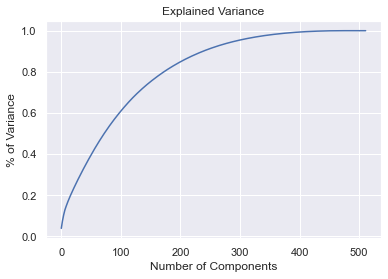

In [101]:
plt.figure()
plt.plot(np.cumsum(explained_variance))
plt.xlabel("Number of Components")
plt.ylabel("% of Variance")
plt.title("Explained Variance")
plt.show()

**Insights:** We can see that with about 300 features, about 90% of the data is explained. Amazing! We can probably even do fewer since the goal is to achieve at least 80% of the variance explained.

Now we need to figure out which of these columns are the ones contributing the most to `SalePrice`.

In [102]:
# the number of features I think we should include in our regression
# this is about 85% of the data
# alternatively, we could try 300
pca_num = 250

pca_df = pd.concat([pd.DataFrame(data={"Features": data.columns.tolist()}), 
                   pd.DataFrame(data={"Variance Squared": explained_variance**2})], 
                   axis=1).sort_values(by="Variance Squared", ascending=False)[0:pca_num]
pca_df

,Features,Variance Squared
0,LotFrontage,0.001519
1,LotArea,0.000407
2,MasVnrArea,0.000269
3,BsmtFinSF1,0.000231
4,BsmtFinSF2,0.000193
...,...,...
245,YearRemodAdd_1961,0.000001
246,YearRemodAdd_1962,0.000001
247,YearRemodAdd_1963,0.000001
248,YearRemodAdd_1964,0.000001


In [103]:
# How much of the variance we are explaining with pca_df
np.sqrt(pca_df["Variance Squared"]).sum()

0.9122797609932585

Let's make `X` now only contain the features that are in `pca_df`.

In [104]:
pca_features = pca_df["Features"].tolist()
X_new = data.loc[:, pca_features]
X_new.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,YearRemodAdd_1956,YearRemodAdd_1957,YearRemodAdd_1958,YearRemodAdd_1959,YearRemodAdd_1960,YearRemodAdd_1961,YearRemodAdd_1962,YearRemodAdd_1963,YearRemodAdd_1964,YearRemodAdd_1965
0,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,...,0,0,0,0,0,0,0,0,0,0
1,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,...,0,0,0,0,0,0,0,0,0,0
2,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,...,0,0,0,0,0,0,0,0,0,0
3,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,...,0,0,0,0,0,0,0,0,0,0
4,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,...,0,0,0,0,0,0,0,0,0,0


We can resplit the data with the proper features that we can now model with.

In [105]:
# our edited train set
X = X_new[:len(train)]

# our edited test set
test2 = X_new[len(train):]

## First ML Model: Ridge Regression

The first thing we should do before building our regression model is splitting our `X` dataframe. Notice that `X` is just our training set that has been cleaned and feature engineered. We want to split our training set into a train and validation set so that we are able to test our model on that validation set before submitting to Kaggle.

### Ridge Regression
Let's use Ridge Regression first. The reason we want to do this is because it is better to model data that may suffer from collinearity. We saw that some variables may very well depend on one another (such as "TotalSF").    

To build a strong Ridge Regression model, we can use `GridSearchCV` to determine what is the best alpha value for ridge.

In [106]:
def create_model(X, y, test_set, model, model_type, param_grid):
    """
    This creates the best model given a basic model, such as Ridge, Lasso, or ElasticNet. We pass in a param_grid
    for GridSearchCV for reproducibility. 
    
    Inputs:
        X: our feature matrix
        y: our predictor vector, the log of "SalePrice"
        test_set: our test matrix that we wish to predict on, containing the same features as X
        model: an sklearn model, set with random_state=42 for reproducibility
        model_type: str, one of ["ridge", "lasso", "lasso-unselected-feats", "elastic-net", "random-forest"]
    """
    ## SETUP
    # Only allowing 30% of the data go into testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # for reproducibility

    print("Train shapes:")
    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")

    print("\nTest shapes:")
    print(f"X_test: {X_test.shape}")
    print(f"y_test: {y_test.shape}")

    # Instantiate the GridSearchCV object: model_cv
    model_cv = GridSearchCV(model, param_grid=param_grid, cv=5)

    # Fit it to the data
    model_cv.fit(X_train, y_train)

    # Print the tuned parameter and score
    print(f"\nTuned {model_type} Regression Parameters: {model_cv.best_params_}")
    print(f"Best score is {model_cv.best_score_}")
    
    ## EVALUATION
    y_train_pred = model_cv.predict(X_train)
    y_test_pred = model_cv.predict(X_test)
    
    fig, axes = plt.subplots(2, 1, figsize=(15,15))
    # visualizing how well we predicted on training
    axes[0].scatter(y_train, y_train_pred)
    axes[0].set_title(f"{model_type} Train: True vs. Predicted")
    axes[0].set_xlabel("Train Values")
    axes[0].set_ylabel("Predicted Train Values")
    
    # visualizing how well we predicted on validation
    axes[1].scatter(y_test, y_test_pred)
    axes[1].set_title(f"{model_type} Validation: True vs. Predicted")
    axes[1].set_xlabel("Test Values")
    axes[1].set_ylabel("Predicted Test Values")
    
    plt.show();
    
    # printing metrics information
    print(f"\n{model_type} Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_test_pred)}")
    print(f"{model_type} Mean Squared Error: {metrics.mean_squared_error(y_test, y_test_pred)}")
    print(f"** {model_type} Root Mean Squared Error **: {np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))}")
    print((f"{model_type} Root Mean Squared Logarithmic \
    Error: {np.sqrt(metrics.mean_squared_log_error(y_test, y_test_pred))}"))
    
    ## TEST PREDICTIONS
    # creating our test submissions and a csv file to submit to Kaggle
    # First, we have to fit to our entire training data, and then predict on our test set
    # We also need to change the SalePrice value back to its original, non-logarithmic form
    test_submit = 0
    if "ridge" in model_type:
        model_cv.fit(X, y)
        test_pred = model_cv.predict(test_set)
        test_pred = np.expm1(test_pred)
        test_pred2 = []
        for i in np.arange(len(test_pred)):
            test_pred2.append(test_pred[i][0])

        assert len(test_pred2) == len(test_set)
        test_submit = pd.DataFrame(data={"Id": test_id.tolist(), "SalePrice": test_pred2})
        print()
        print(test_submit.head())
    else:
        model_cv.fit(X, y)
        test_pred = model_cv.predict(test_set)
        test_pred = np.expm1(test_pred)

        assert len(test_pred) == len(test_set)
        test_submit = pd.DataFrame(data={"Id": test_id.tolist(), "SalePrice": test_pred})
        print()
        print(test_submit.head())
    
    test_submit.to_csv(f"{model_type}-regression.csv", index=False)

Train shapes:
X_train: (1022, 250)
y_train: (1022, 1)

Test shapes:
X_test: (438, 250)
y_test: (438, 1)

Tuned ridge Regression Parameters: {'alpha': 0.7000000000000001, 'fit_intercept': True, 'normalize': True}
Best score is 0.81633361632467


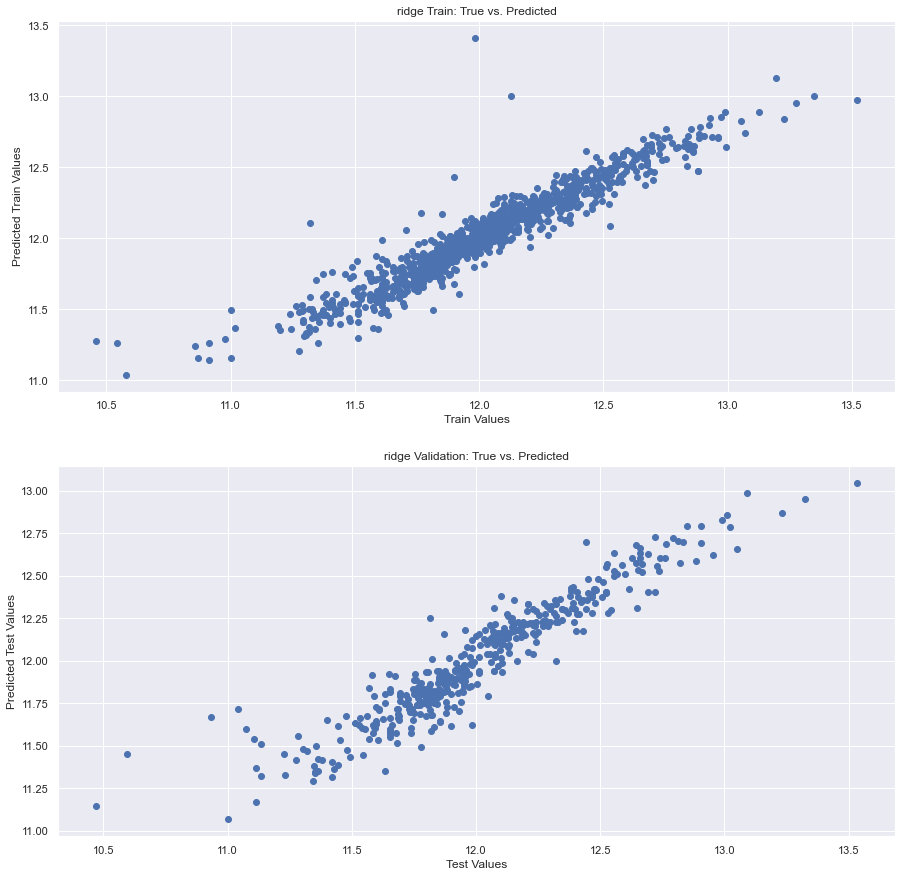


ridge Mean Absolute Error: 0.09640656047381022
ridge Mean Squared Error: 0.020527403085428605
** ridge Root Mean Squared Error **: 0.1432738743994473
ridge Root Mean Squared Logarithmic     Error: 0.011190715424308419

     Id      SalePrice
0  1461  113161.597033
1  1462  147033.155893
2  1463  176073.459462
3  1464  195606.784386
4  1465  199854.452703


In [107]:
# Setup the hyperparameter grid
alph = np.arange(0, 10.1, 0.1)
fit_intercept = np.array([True, False])
normalize = np.array([True, False])
param_grid = {'alpha': alph, "fit_intercept": fit_intercept, "normalize": normalize}

create_model(X, y, test2, model=Ridge(random_state=42), model_type="ridge", param_grid=param_grid)

Notice that Kaggle looks at the Root Mean Squared Logarithmic Error, but I also wanted to print out other metrics.  
  
We can see that we did pretty well when predicting the training set, except for a few outliers. We still did very well on the test set as well. We see that really low values are not doing the best at predictions.    

Seems like we have a very low error! Great, let's use this for predictions and submit to Kaggle. 

What score does this give us on Kaggle? Remember, the smaller the better!  
- **0.14855**

## Second ML Model: Lasso Regression

Lasso regression makes some coefficients exactly 0. This may or may not be useful for this problem, but I wanted to try it out to see how it compares to Ridge.

Train shapes:
X_train: (1022, 250)
y_train: (1022, 1)

Test shapes:
X_test: (438, 250)
y_test: (438, 1)

Tuned lasso Regression Parameters: {'alpha': 1.5000000000000002, 'fit_intercept': True, 'normalize': False}
Best score is 0.6055893302155447


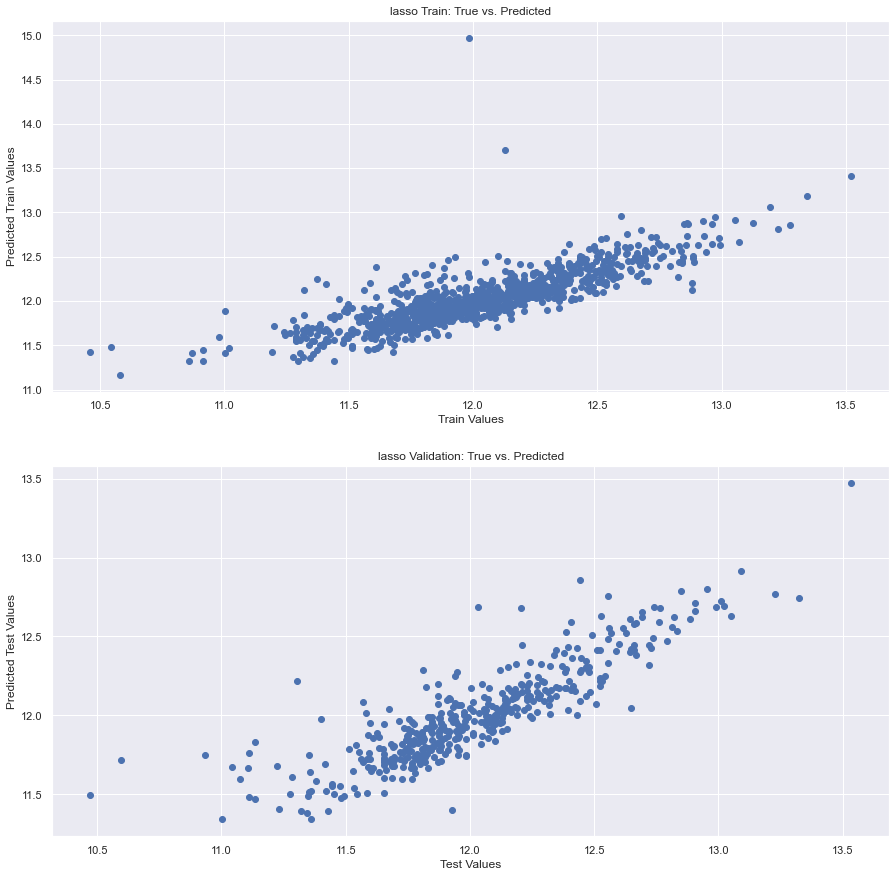


lasso Mean Absolute Error: 0.14840523757181062
lasso Mean Squared Error: 0.04347949141702717
** lasso Root Mean Squared Error **: 0.20851736478535107
lasso Root Mean Squared Logarithmic     Error: 0.016223135267555495

     Id      SalePrice
0  1461  157135.592134
1  1462  163836.549136
2  1463  180687.569217
3  1464  183982.046740
4  1465  163663.957722


In [108]:
# Setup the hyperparameter grid
alph = np.arange(0.1, 10.1, 0.1)
fit_intercept = np.array([True, False])
normalize = np.array([True, False])
param_grid = {'alpha': alph, "fit_intercept": fit_intercept, "normalize": normalize}

# had to increase max_iter from the default 1000 to 25000 because it would not converge
create_model(X, y, test2, model=Lasso(random_state=42, max_iter=25000), model_type="lasso", param_grid=param_grid)

**Insights:** Clearly, Lasso is not doing very well. The score is much lower than Ridge and the Root Mean Squared Logarithmic Error is also higher than Ridge. It seems like Lasso performed well on the test set, but not very well on the training set. I'll submit this to Kaggle just to compare.

What score does this give us on Kaggle? Remember, the smaller the better!  
- **0.22671**  
We clearly did worse! Lasso is not the way to go in this situation.

## Third ML Model: Elastic Net Regression

Elastic Net is a combination of Lasso and Ridge, so maybe this could potentially make our model more accurate. Let's give it a try. First, we will ensure that we are using `X` with selected features from PCA.

Train shapes:
X_train: (1022, 250)
y_train: (1022, 1)

Test shapes:
X_test: (438, 250)
y_test: (438, 1)

Tuned elastic-net Regression Parameters: {'alpha': 3.0000000000000004, 'fit_intercept': True, 'normalize': False}
Best score is 0.6055896785398815


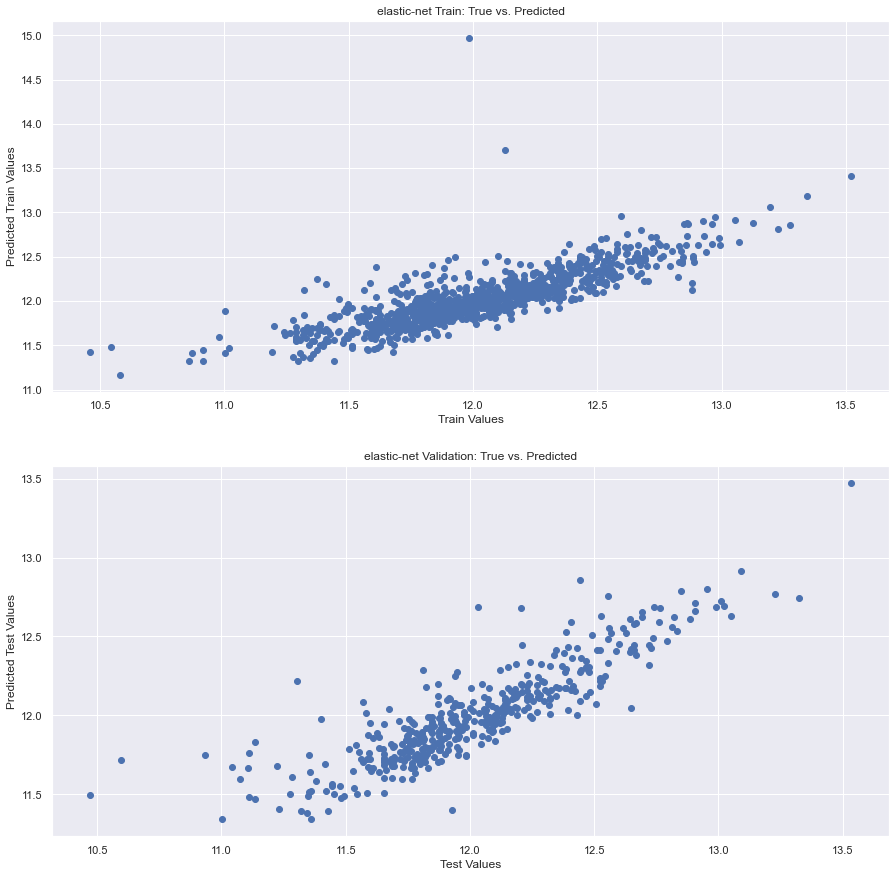


elastic-net Mean Absolute Error: 0.14840539374477094
elastic-net Mean Squared Error: 0.043479437916934274
** elastic-net Root Mean Squared Error **: 0.20851723649841103
elastic-net Root Mean Squared Logarithmic     Error: 0.016223128470221268

     Id      SalePrice
0  1461  157358.570289
1  1462  163691.752849
2  1463  180758.206656
3  1464  184185.042352
4  1465  164028.614354


In [109]:
# had to increase max_iter from the default 1000 to 70000 because it would not converge
create_model(X, y, test2, model=ElasticNet(random_state=42, max_iter=70000), model_type="elastic-net", 
             param_grid=param_grid)

What score does this give us on Kaggle? Remember, the smaller the better!  
- **0.22668**  
ElasticNet did a bit better than Lasso, but still not good compared to Ridge.

## Fourth ML Model: Random Forest Regression

I want to try a random forest regression because it not only predicts future values very well, but it also tends to be extremely accurate. Like the other models we have created, we will find the best parameters through GridSearchCV.

Train shapes:
X_train: (1022, 250)
y_train: (1022,)

Test shapes:
X_test: (438, 250)
y_test: (438,)

Tuned random-forest-250 Regression Parameters: {'n_estimators': 94}
Best score is 0.8300680275780419


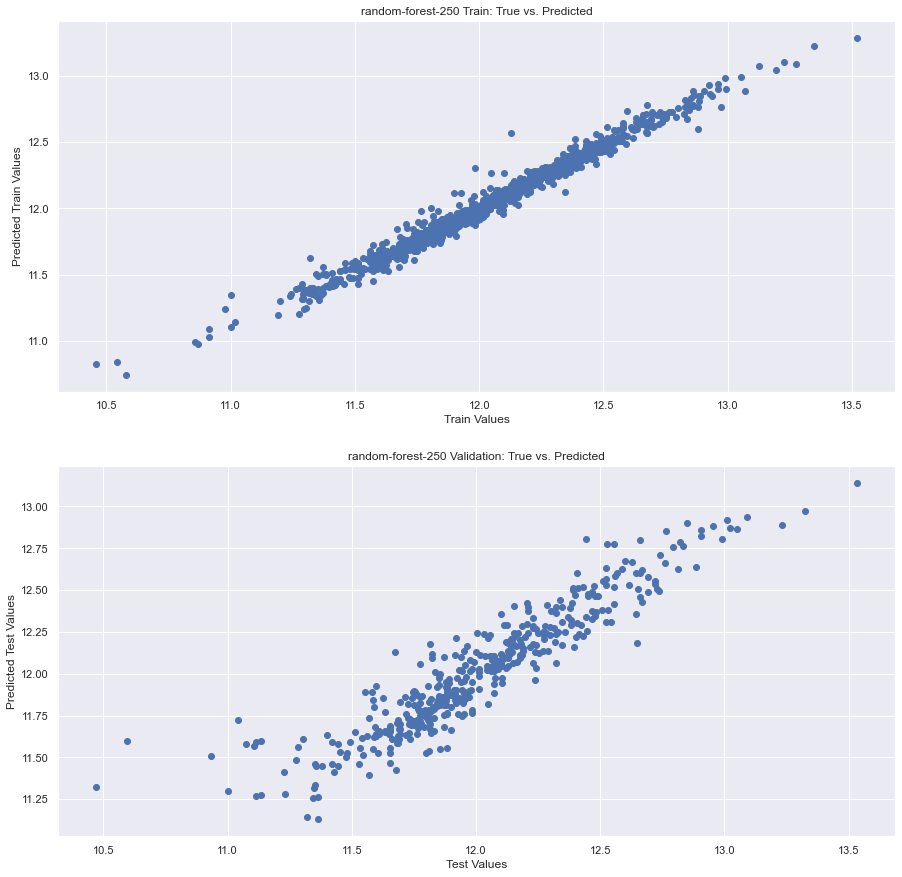


random-forest-250 Mean Absolute Error: 0.10725358884215226
random-forest-250 Mean Squared Error: 0.02410007587942705
** random-forest-250 Root Mean Squared Error **: 0.15524199135358657
random-forest-250 Root Mean Squared Logarithmic     Error: 0.012172690702655059

     Id      SalePrice
0  1461  122157.350361
1  1462  158530.942468
2  1463  181728.943505
3  1464  181274.808185
4  1465  194815.376270


In [110]:
# Setup the hyperparameter grid for random forest regression
n_est = np.arange(10, 150)
#max_dep = np.arange(1, 100)
# "max_depth": max_dep}
param_grid = {'n_estimators': n_est}

# create the model
create_model(X, np.array(y["SalePrice"].tolist()), test2, model=RandomForestRegressor(random_state=42), 
             model_type="random-forest-250", param_grid=param_grid)

**Insights:** We see that Random Forest is predicting the outliers in a better way based on the scatter plot, but our Root Mean Squared Logarithmic Error is somehow higher. Maybe because it is not predicting low test values well.

What score does this give us on Kaggle? Remember, the smaller the better!  
- **0.16484**  
Although this is much better than Lasso and ElasticNet, this is still not better than Ridge regression. Maybe we could select more features, which I will try below.

### Random Forest Take 2: More Features
Previously, I selected 250 features for our feature matrix `X` because these many features explained roughly 85% of the data. Maybe we should instead select 300 or 350 to achieve a higher accuracy. I must caution that this may cause overfitting, but we'll see what happens!

In [111]:
def create_feature_matrix(pca_num):
    """
    Creates our feature matrix for our regression models based on how many features we would like to include.
    
    Inputs:
        pca_num: int, how many features we want in our feature matrix
        
    Outputs:
        X: our feature matrix for training our models
        test2: a second version of our test set that only contains the same features as X
    """
    # creating a df sorted by variance explained squared to select our top pca_num features
    pca_df = pd.concat([pd.DataFrame(data={"Features": data.columns.tolist()}), 
                   pd.DataFrame(data={"Variance Squared": explained_variance**2})], 
                   axis=1).sort_values(by="Variance Squared", ascending=False)[0:pca_num]
    
    print()
    print(pca_df.head())
    
    # How much of the variance we are explaining with pca_df
    var_squared = np.sqrt(pca_df["Variance Squared"]).sum()
    print(f"\nVariance explained: {var_squared}")
    
    # creating the feature matrix based on top pca_num features that explain the most variance
    pca_features = pca_df["Features"].tolist()
    X_new = data.loc[:, pca_features]
    
    ## splitting our edited train and test sets
    # our edited train set
    X = X_new[:len(train)]

    # our edited test set
    test2 = X_new[len(train):]
    
    return (X, test2)

In [112]:
X, test2 = create_feature_matrix(300)


      Features  Variance Squared
0  LotFrontage          0.001519
1      LotArea          0.000407
2   MasVnrArea          0.000269
3   BsmtFinSF1          0.000231
4   BsmtFinSF2          0.000193

Variance explained: 0.9540097429413645


Train shapes:
X_train: (1022, 300)
y_train: (1022,)

Test shapes:
X_test: (438, 300)
y_test: (438,)

Tuned random-forest-300 Regression Parameters: {'n_estimators': 95}
Best score is 0.8293615413863165


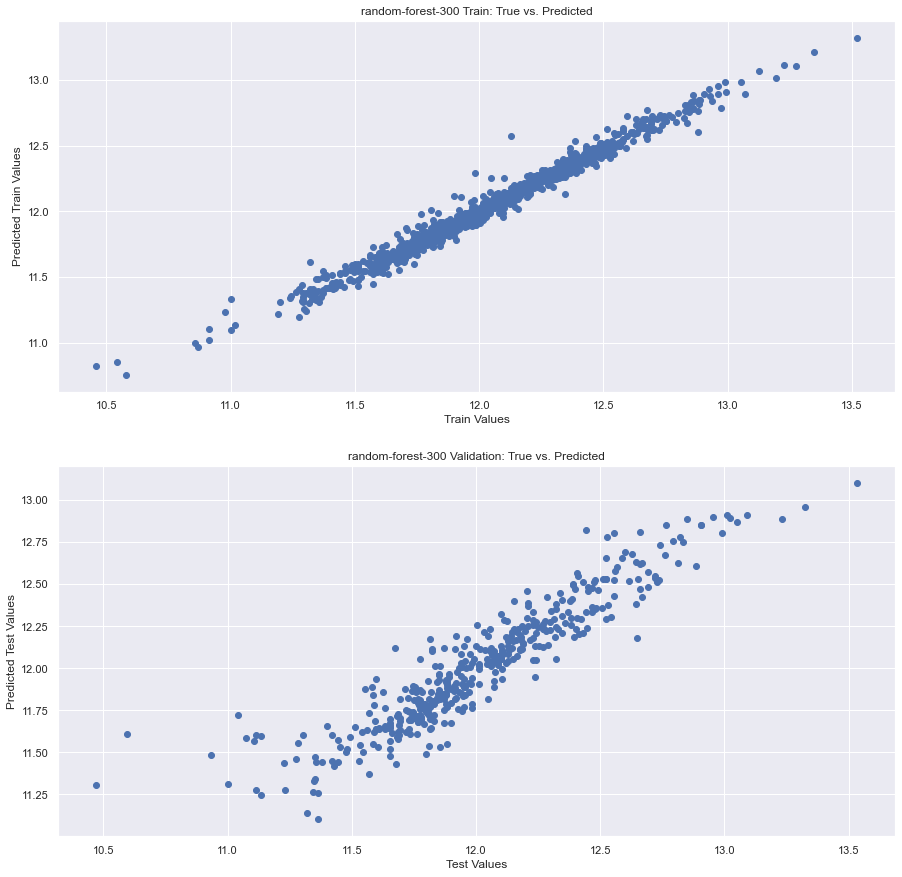


random-forest-300 Mean Absolute Error: 0.10641451924309726
random-forest-300 Mean Squared Error: 0.024212373776787616
** random-forest-300 Root Mean Squared Error **: 0.15560325760339214
random-forest-300 Root Mean Squared Logarithmic     Error: 0.012196329598854961

     Id      SalePrice
0  1461  121453.498876
1  1462  155597.287651
2  1463  186753.110448
3  1464  181311.912686
4  1465  194134.222254


In [114]:
# create the model with same param_grid from the last random forest regressor
create_model(X, np.array(y["SalePrice"].tolist()), test2, model=RandomForestRegressor(random_state=42), 
             model_type="random-forest-300", param_grid=param_grid)

**Insights:** The Root Mean Squared Error increased. The training data looks great in terms of prediction but the test is not doing so well. 

What score does this give us on Kaggle? Remember, the smaller the better!  
- **0.16663**  
This has gotten worse, meaning that Random Forest is not doing well as we increase the number of features in our training set. Let's try Ridge regression again with the increased number of features.

## Second to Last Model: Back to Ridge Regression
Random forests seem to not be doing too well, even as we added features. Our best model was Ridge Regression, so we should try to create a new model with the same 300 features we just created for our previous random forest model.

Train shapes:
X_train: (1022, 300)
y_train: (1022, 1)

Test shapes:
X_test: (438, 300)
y_test: (438, 1)

Tuned ridge-300 Regression Parameters: {'alpha': 1.0, 'fit_intercept': True, 'normalize': True}
Best score is 0.8153557715945456


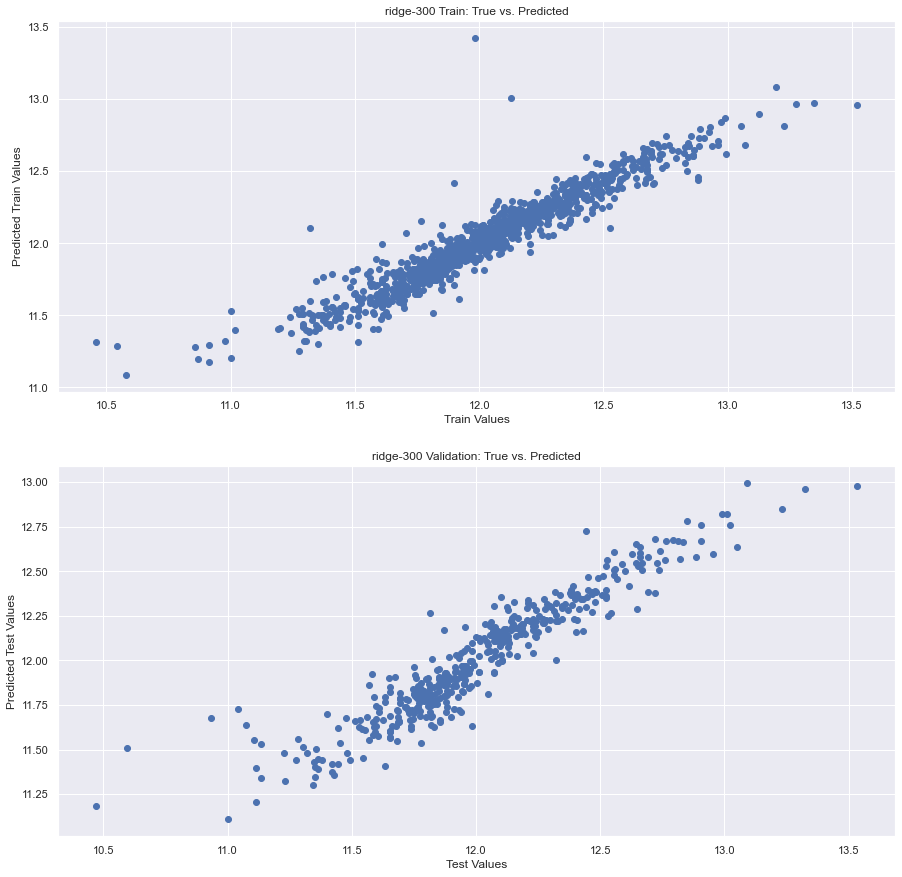


ridge-300 Mean Absolute Error: 0.09934051459966006
ridge-300 Mean Squared Error: 0.02201795495837536
** ridge-300 Root Mean Squared Error **: 0.14838448354991624
ridge-300 Root Mean Squared Logarithmic     Error: 0.011571522823220076

     Id      SalePrice
0  1461  111567.992294
1  1462  145972.954893
2  1463  174039.823996
3  1464  194240.965163
4  1465  194744.210429


In [115]:
# Setup the hyperparameter grid
alph = np.arange(0, 10.5, 0.5)
fit_intercept = np.array([True, False])
normalize = np.array([True, False])
param_grid = {'alpha': alph, "fit_intercept": fit_intercept, "normalize": normalize}

create_model(X, y, test2, model=Ridge(random_state=42), model_type="ridge-300", param_grid=param_grid)

What score does this give us on Kaggle? Remember, the smaller the better!  
- **0.14894**  
Wow! Ridge regression is definitely doing better than Random Forests, even though the scatterplot doesn't look very well fit. Maybe we are overfitting with random forests. Let's try Ridge again with 350 features now.

In [116]:
X, test2 = create_feature_matrix(350)


      Features  Variance Squared
0  LotFrontage          0.001519
1      LotArea          0.000407
2   MasVnrArea          0.000269
3   BsmtFinSF1          0.000231
4   BsmtFinSF2          0.000193

Variance explained: 0.979337862186067


Train shapes:
X_train: (1022, 350)
y_train: (1022, 1)

Test shapes:
X_test: (438, 350)
y_test: (438, 1)

Tuned ridge-350 Regression Parameters: {'alpha': 1.0, 'fit_intercept': True, 'normalize': True}
Best score is 0.8277546828438809


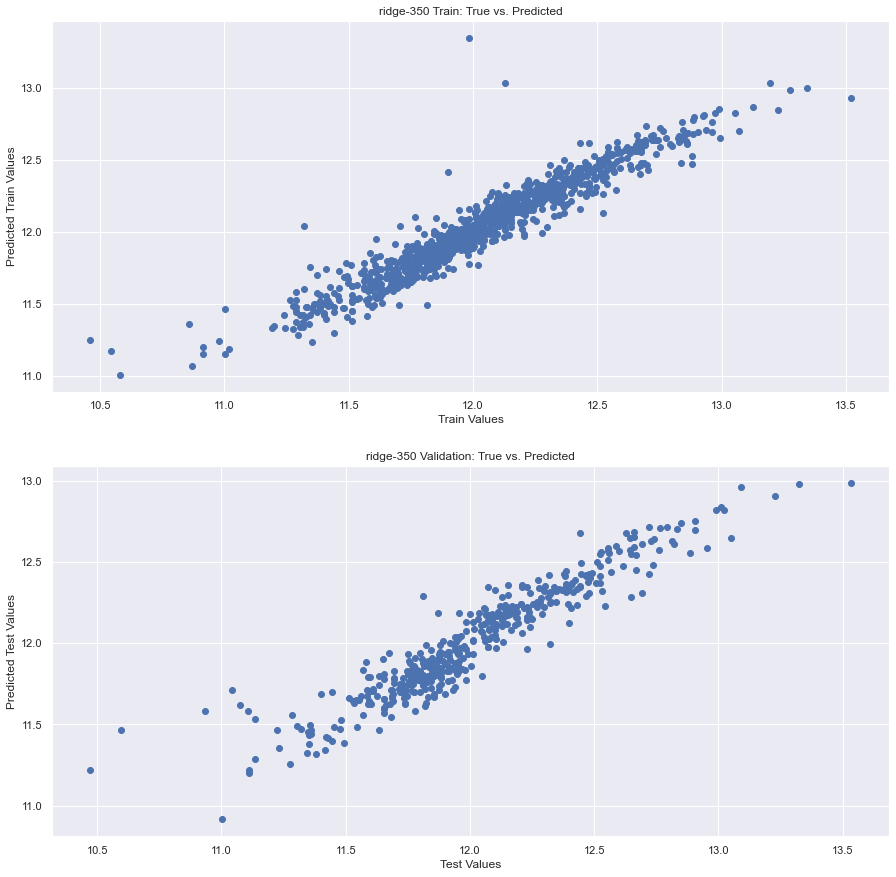


ridge-350 Mean Absolute Error: 0.0965699212571273
ridge-350 Mean Squared Error: 0.02065726984931882
** ridge-350 Root Mean Squared Error **: 0.14372637144699235
ridge-350 Root Mean Squared Logarithmic     Error: 0.011210189101947729

     Id      SalePrice
0  1461  114091.188003
1  1462  140321.886426
2  1463  176302.843210
3  1464  197407.831271
4  1465  193715.566830


In [117]:
# # create the model with same param_grid from the last ridge regression
create_model(X, y, test2, model=Ridge(random_state=42), model_type="ridge-350", param_grid=param_grid)

**Insights:** The scores are slowly improving because I see them decreasing as we add more features.

What score does this give us on Kaggle? Remember, the smaller the better!  
- **0.14399**  
This is a much better improvement from the Ridge regression model with 300 features!

## Last Model: Trying Out XGBoost (for next time; I am running into errors)
I want to try this model because I am seeing this as a common regressor for this Kaggle dataset when looking over the `Discussions` tab. Although we haven't learned it, I'd be curious to see how it acts on this model.    

Reasons why we may want to use XGBoost (based on my Google searches):  
- It is an ensemble learning model, meaning it combines base learners to create highly accurate models.  
- An efficient implementation of gradient boosting.  
- Constructed from decision tree models, making it highly accurate.

First, I'll recreate my `create_model()` function because XGBoost requires us to transform the data into a DMatrix.

In [118]:
def create_model_xgboost(X, y, test_set, model, param_grid, model_type):
    """
    This creates the best model given a basic XGBoost model. We pass in a param_grid
    for GridSearchCV for reproducibility. 
    
    Inputs:
        X: our feature matrix
        y: our predictor vector, the log of "SalePrice"
        test_set: our test matrix that we wish to predict on, containing the same features as X
        model: an sklearn model, set with random_state=42 for reproducibility
        model_type: str, which should be "xgboost"
    """
    ## SETUP
    # Only allowing 30% of the data go into testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # for reproducibility

    print("Train shapes:")
    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")

    print("\nTest shapes:")
    print(f"X_test: {X_test.shape}")
    print(f"y_test: {y_test.shape}")
    
    # train and test set are converted to DMatrix objects, as it is required by learning API
    # results in better accuracy
    train_dmatrix = xg.DMatrix(data=X_train, label=y_train)
    test_dmatrix = xg.DMatrix(data=X_test, label=y_test)

    # Instantiate the GridSearchCV object: model_cv
    model_cv = GridSearchCV(model, param_grid=param_grid, cv=5)

    # Fit it to the data
    model_cv.train(dtrain=train_dmatrix)

    # Print the tuned parameter and score
    print(f"\nTuned {model_type} Regression Parameters: {model_cv.best_params_}")
    print(f"Best score is {model_cv.best_score_}")
    
    ## EVALUATION
    y_train_pred = model_cv.predict(train_dmatrix)
    y_test_pred = model_cv.predict(test_dmatrix)
    
    fig, axes = plt.subplots(2, 1, figsize=(15,15))
    # visualizing how well we predicted on training
    axes[0].scatter(y_train, y_train_pred)
    axes[0].set_title(f"{model_type} Train: True vs. Predicted")
    axes[0].set_xlabel("Train Values")
    axes[0].set_ylabel("Predicted Train Values")
    
    # visualizing how well we predicted on validation
    axes[1].scatter(y_test, y_test_pred)
    axes[1].set_title(f"{model_type} Validation: True vs. Predicted")
    axes[1].set_xlabel("Test Values")
    axes[1].set_ylabel("Predicted Test Values")
    
    plt.show();
    
    # printing metrics information
    print(f"\n{model_type} Mean Absolute Error: {metrics.mean_absolute_error(y_test, y_test_pred)}")
    print(f"{model_type} Mean Squared Error: {metrics.mean_squared_error(y_test, y_test_pred)}")
    print(f"** {model_type} Root Mean Squared Error **: {np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))}")
    print((f"{model_type} Root Mean Squared Logarithmic \
    Error: {np.sqrt(metrics.mean_squared_log_error(y_test, y_test_pred))}"))
    
    ## TEST PREDICTIONS
    # first, transform our entire train (X) set into DMatrix
    # then, also transform our test_set into DMatrix
    # creating our test submissions and a csv file to submit to Kaggle
    # First, we have to fit to our entire training data, and then predict on our test set
    # We also need to change the SalePrice value back to its original, non-logarithmic form
    train = xg.DMatrix(data=X, label=y)
    test = xg.DMatrix(data=test_set)
    
    model_cv.train(dtrain=train)
    test_pred = model_cv.predict(test_set)
    test_pred = np.expm1(test_pred)

    assert len(test_pred) == len(test_set)
    test_submit = pd.DataFrame(data={"Id": test_id.tolist(), "SalePrice": test_pred})
    print()
    print(test_submit.head())
    
    test_submit.to_csv(f"{model_type}-regression.csv", index=False)

### XGBoost with 250 Features

In [119]:
X, test2 = create_feature_matrix(250)


      Features  Variance Squared
0  LotFrontage          0.001519
1      LotArea          0.000407
2   MasVnrArea          0.000269
3   BsmtFinSF1          0.000231
4   BsmtFinSF2          0.000193

Variance explained: 0.9122797609932585


In [120]:
# # Setup the hyperparameter grid
# gamma = np.arange(0, 10.5, 0.5)
# max_depth = np.arange(0, 11, 0.5)
# min_child_weight = np.arange(0, 10.5, 0.5)
# sub_sample = np.arange(0.1, 1.1, 0.1)
# sampling_method = np.array(["uniform", "gradient_based"])
# alpha = np.arange(0, 10.5, 0.5)
# lambd = np.arange(0, 10.5, 0.5)

# param_grid = {"gamma": gamma, "max_depth": max_depth, "min_child_weight": min_child_weight, 
#               "subsample": sub_sample, "sampling_method": sampling_method, 
#               "alpha": alpha, "lambda": lambd}

# create_model(X, y, test2, model=xgb.XGBRegressor(seed=42), param_grid=param_grid, model_type="xgboost-250")

### XGBoost with 300 Features

In [121]:
# X, test2 = create_feature_matrix(300)

In [122]:
# create_model(X, y, test2, model=xgb.XGBRegressor(seed=42), param_grid=param_grid, model_type="xgboost-300")

### XGBoost with 350 Features

In [123]:
# X, test2 = create_feature_matrix(350)

In [124]:
# create_model(X, y, test2, model=xgb.XGBRegressor(seed=42), param_grid=param_grid, model_type="xgboost-350")

# Conclusion

Our best model so far is Ridge regression trained on the top 350 features that explain the most variance in the data. This resulted in our best score of 0.14399. In the future, I would like to improve my score by trying out different models, like XGBoost. I spent some time trying to get this to work with GridSearchCV, but have run into errors. For now, I am happy with my score!